In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '32'
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import math
import sys
sys.path.append('../')
from pyfd3d import pyfd3d
from pyMKL import pardisoSolver
import pyfd3d.fd3d as fd3d
from scipy.sparse.linalg import qmr, bicgstab

In [2]:
Nz = 210
Npml = np.array([10,10,0])

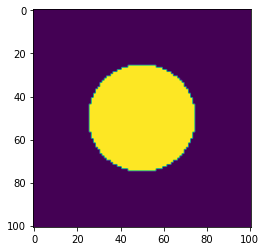

In [3]:
L0 = 1e-6
## specify slab plane
xrange = yrange = np.array([-0.5,0.5])
zrange = [-1,1];
radius = 0.25
Nx = Ny = 101

x = np.linspace(xrange[0], xrange[1], Nx)
y = np.linspace(yrange[0], yrange[1], Ny)
z = np.linspace(zrange[0], zrange[1], Nz)
xx,yy = np.meshgrid(x,y)

slab_plane = 1*np.ones((Nx,Ny))

slab_plane[xx**2+yy**2<radius**2] = 4
plt.imshow(slab_plane)

In [4]:
## integrate slab structure into 3D grid
eps_r = np.ones((Nx,Ny,Nz))
N = [Nx,Ny,Nz]

In [5]:
print(eps_r.shape)
for k in range(0,Nz):
    eps_r[:,:,k] = slab_plane

(101, 101, 210)


## Modal Source

How do we get the modal source? Should we do a TE, TM polarization? Yes

For now, we can test with a point source...

In [6]:
Jz = np.zeros(N); 
Jy = np.zeros(N);
Jx = np.zeros(N);

Jx[Nx//2,Ny//2,15] = 1;
Jy[Nx//2,Ny//2,15] = 1
eps_r_tensor_dict = {
    'eps_xx': eps_r,
    'eps_yy': eps_r.copy(),
    'eps_zz': eps_r.copy(),
}
JCurrentVector = {
    'Jx': Jx,
    'Jy': Jy,
    'Jz': Jz
}


In [7]:
wvlen = 0.51;
print(L0, xrange, yrange, zrange)

A,b, Ch = fd3d.curlcurlE(L0, 
                         wvlen, 
                         xrange, 
                         yrange, 
                         zrange, 
                         eps_r_tensor_dict, 
                         JCurrentVector,Npml, 
                         s = -1
                        )

1e-06 [-0.5  0.5] [-0.5  0.5] [-1, 1]
(6426630,)


## Notes
1. hmmm, seems like bicg-stab fails on this system?

In [8]:
## ilu preconditioner?
from scipy.sparse.linalg import spilu


In [9]:
%%time
x, info = bicgstab(A,b, maxiter = 1000);
print(info)

1000
CPU times: user 1h 19min 59s, sys: 5min 53s, total: 1h 25min 52s
Wall time: 36min 44s


In [10]:
print(info) #system did not converge?

1000


In [11]:
y = Ch@x
print(y.shape, A.shape)

(6426630,) (6426630, 6426630)


In [12]:
M = np.prod(N);
Ex = x[0:M].reshape(N, order = 'F');
Ey = x[M:2*M].reshape(N, order = 'F')
Ez = x[2*M:].reshape(N, order = 'F')

Hx =  y[0:M].reshape(N, order = 'F')
Hy =  y[M:2*M].reshape(N, order = 'F')
Hz =  y[2*M:].reshape(N, order = 'F')


/var/folders/f8/nqg1jnk548j7c367bl0lgl0r0000gn/T/ipykernel_71762/733402907.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


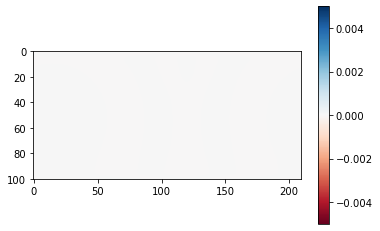

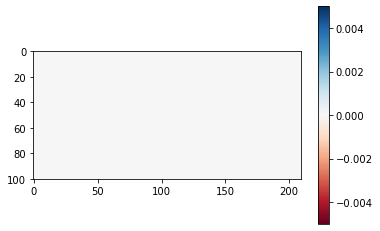

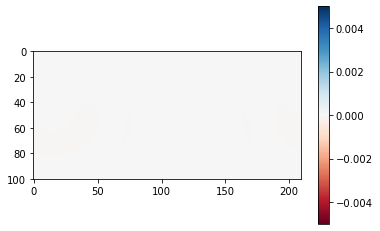

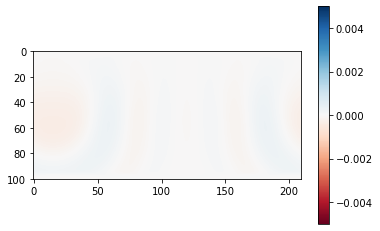

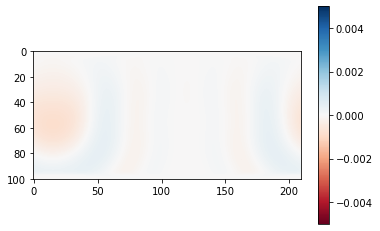

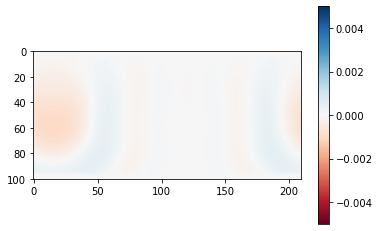

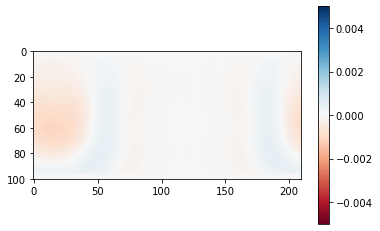

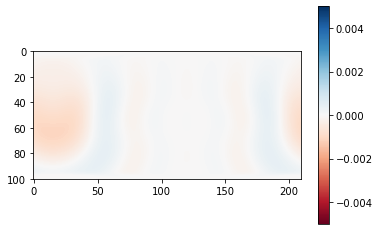

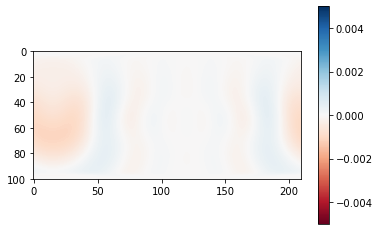

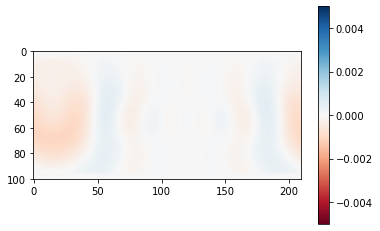

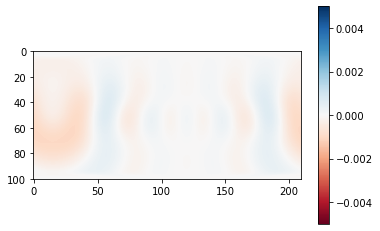

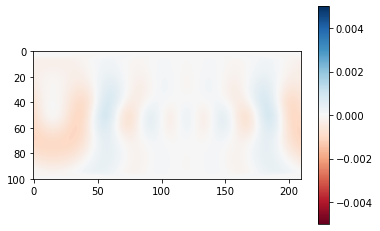

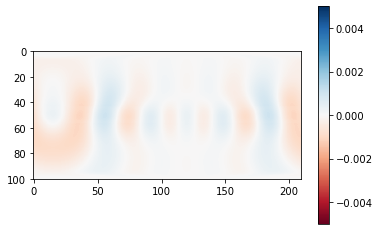

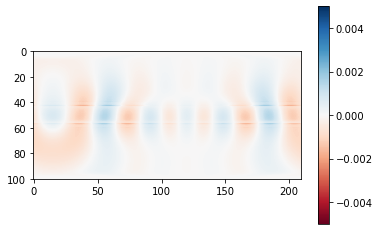

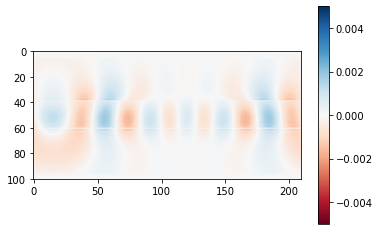

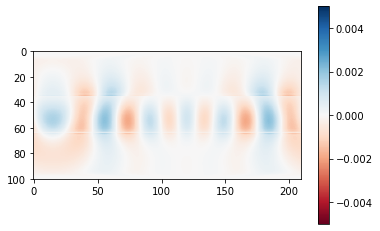

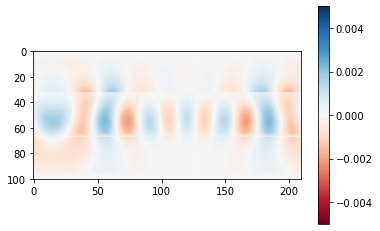

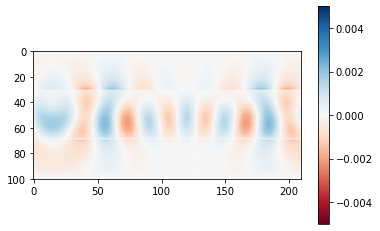

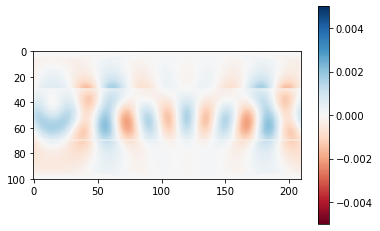

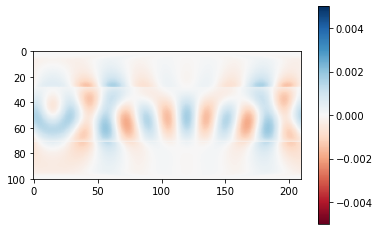

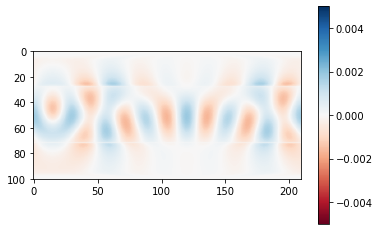

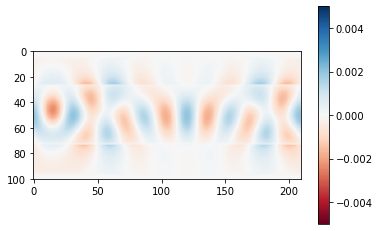

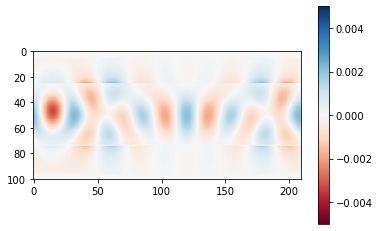

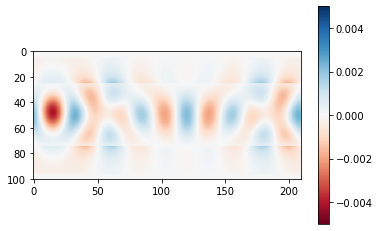

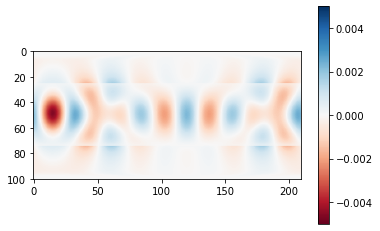

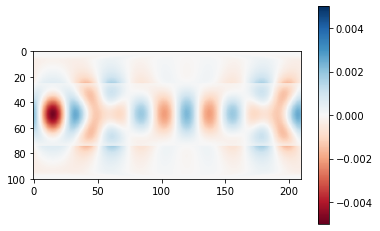

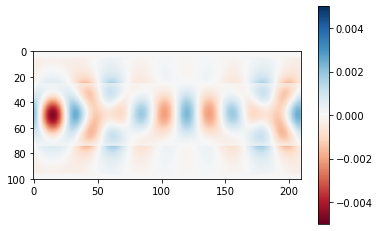

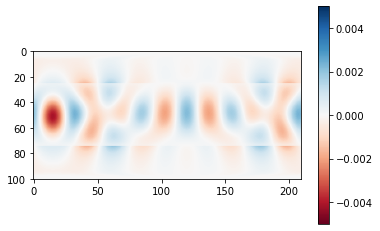

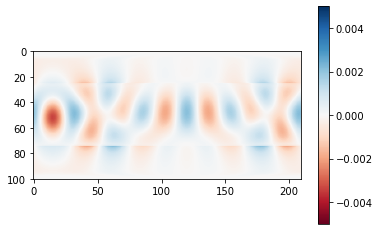

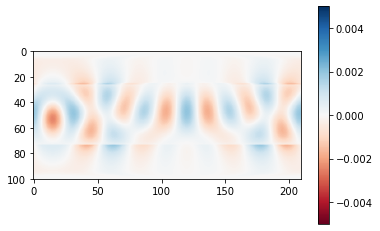

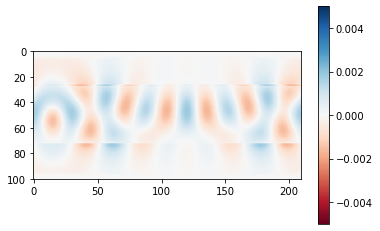

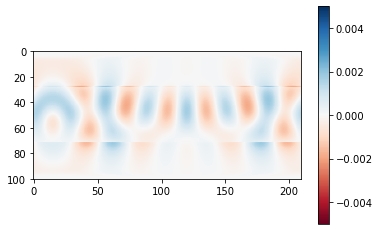

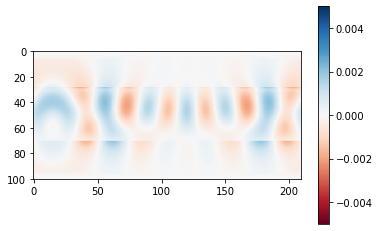

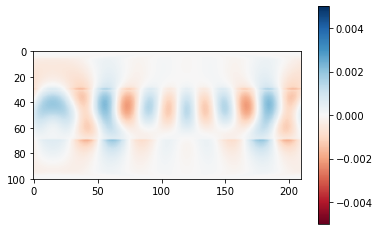

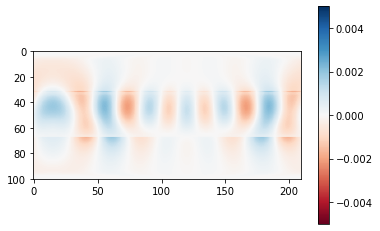

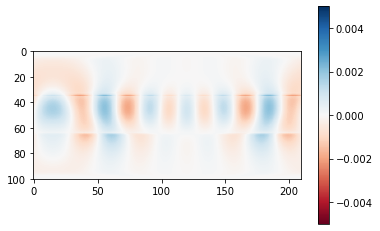

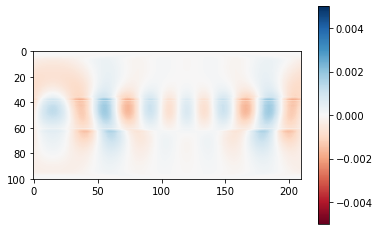

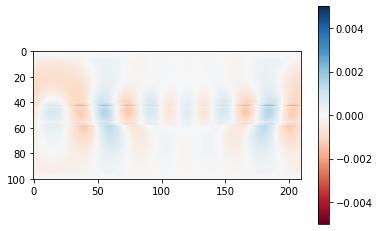

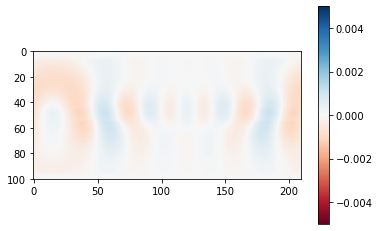

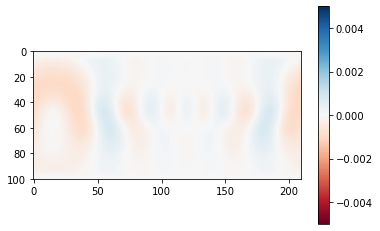

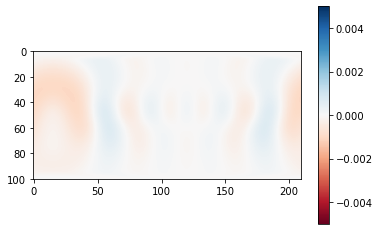

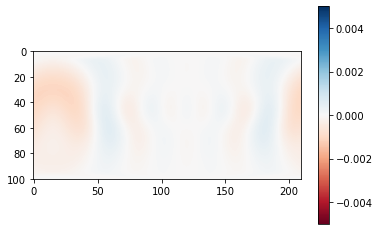

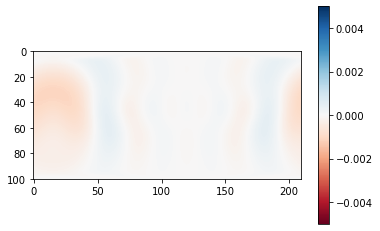

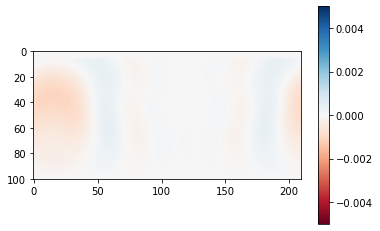

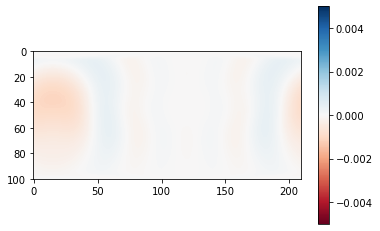

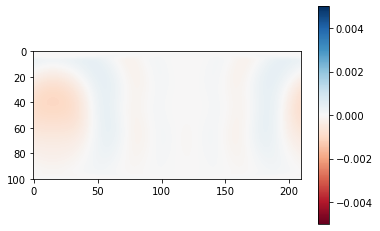

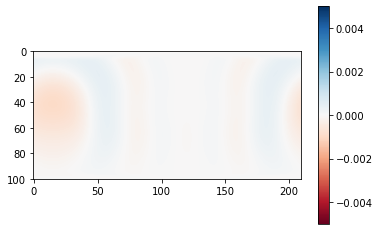

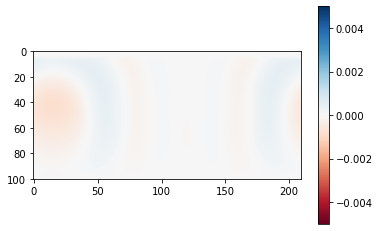

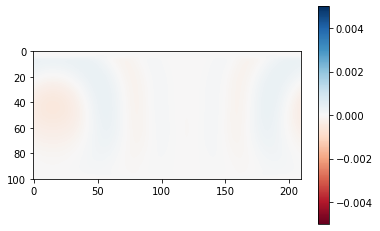

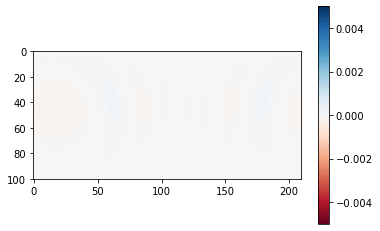

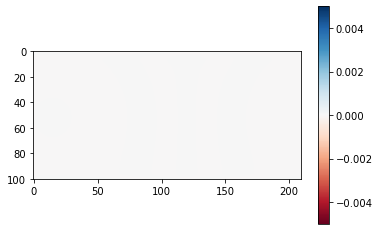

In [13]:
for i in range(0,N[0],2):
    plt.figure()
    #plt.imshow(np.abs(Ex[:,i,:]), cmap = 'hot')
    plt.imshow(np.real(Ex[:,i,:]), cmap = 'RdBu')

    plt.clim(-0.5e-2,0.5e-2)
    plt.colorbar()
    

/var/folders/f8/nqg1jnk548j7c367bl0lgl0r0000gn/T/ipykernel_71762/3278947644.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


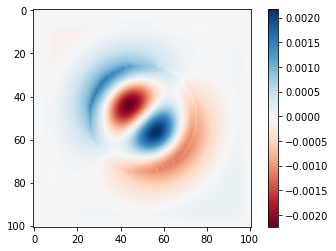

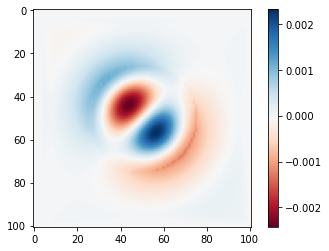

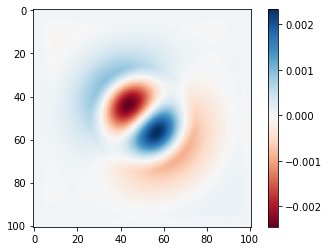

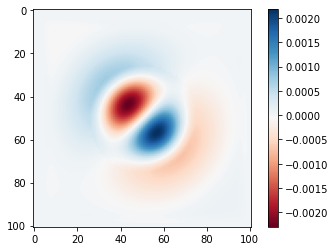

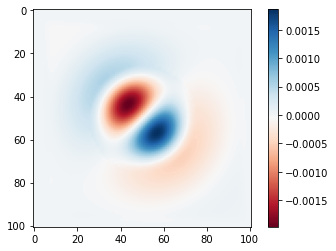

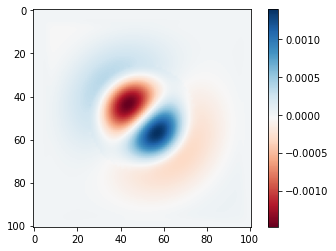

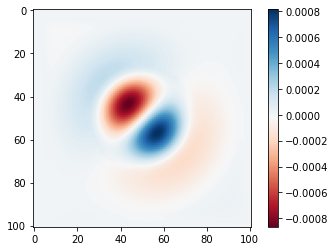

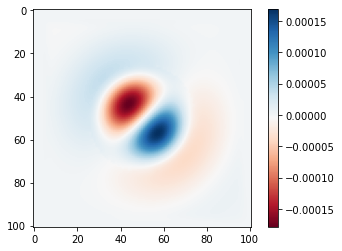

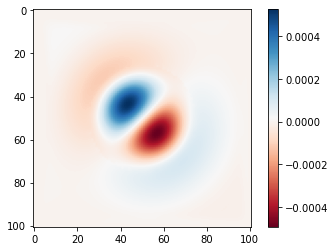

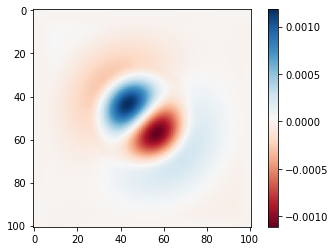

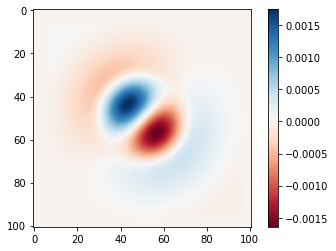

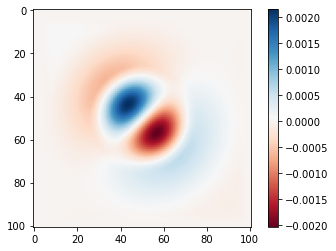

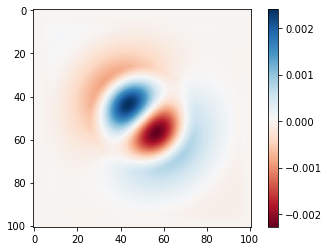

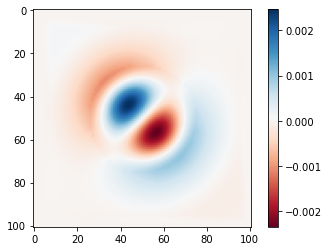

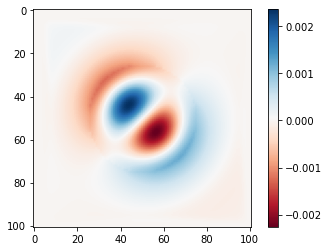

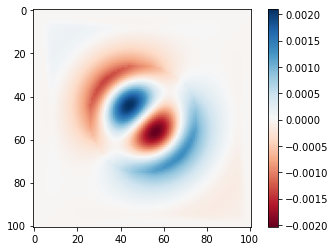

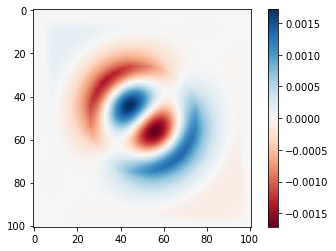

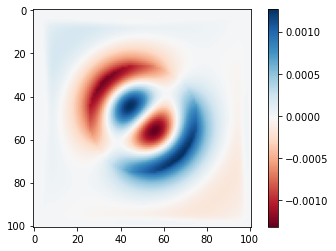

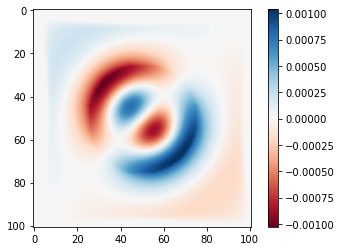

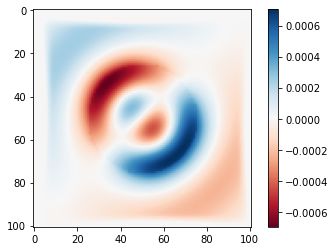

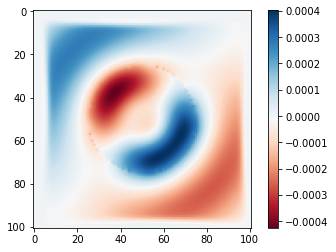

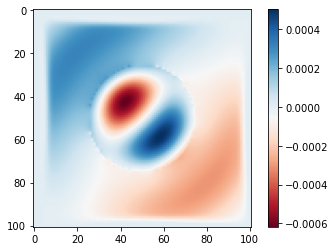

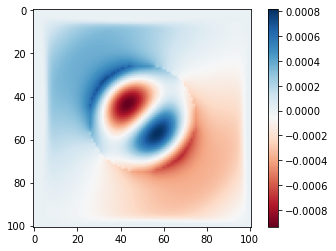

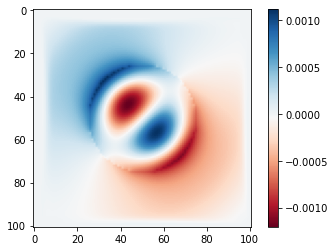

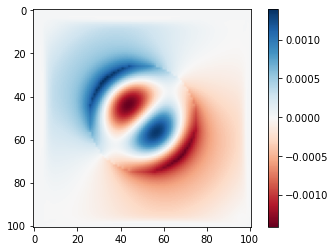

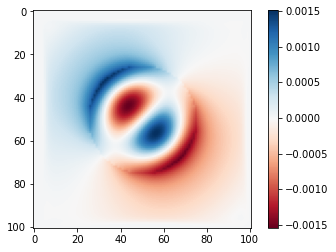

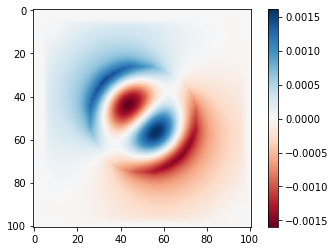

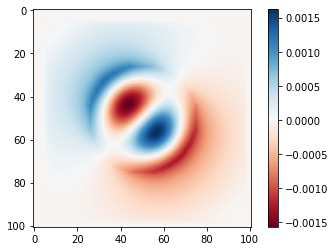

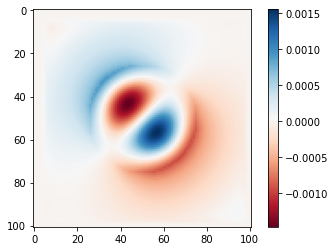

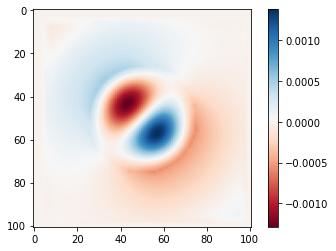

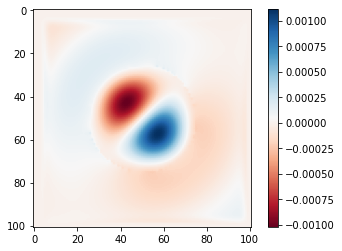

In [ ]:
for i in range(0,N[-1],2):
    plt.figure()
    plt.imshow(np.real(Ez[:,:,i]), cmap = 'RdBu')
    #plt.clim(0,0.5e-2)
    plt.colorbar()

In [ ]:
print('error norm: ',np.linalg.norm(A@x-b)/np.linalg.norm(b))
print('error norm should be small, ideally close to precision')
plt.plot(np.abs(A@x))
plt.plot(np.abs(b))
# plt.figure()
# plt.plot(np.log10(np.abs(A@x)))
# plt.plot(np.log10(np.abs(b)))


In [ ]:
print(np.allclose(A@x, b))

In [ ]:
plt.plot(np.abs(np.log10(x)), '.', markersize = 0.1)

In [ ]:

from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly.graph_objs import *

def get_the_slice(x,y,z, surfacecolor):
    return go.Surface(x=x,
                      y=y,
                      z=z,
                      surfacecolor=surfacecolor,
                      coloraxis='coloraxis')
def get_lims_colors(surfacecolor):# color limits for a slice
    return np.min(surfacecolor), np.max(surfacecolor)

Nx,Ny,Nz = N
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=2, y=2, z=1)
)

x = np.linspace(xrange[0], xrange[1], Nx)
y = np.linspace(yrange[0], yrange[1], Ny)
z = np.linspace(zrange[1], zrange[0], Nz)

yy,zz, = np.meshgrid(y,z, indexing = 'ij');
xx = x[25] * np.ones(yy.shape)

surfcolor_y = (np.abs(Ex[25,:,:]))
surfcolor_z = (np.abs(Ex[:,25,:]))
surfcolor_x = (np.abs(Ex[:,:,60]))

slice_y = get_the_slice(xx,yy,zz, surfcolor_y)
slice_y.update(cmin=0, cmax=0.2e-2)


xx,zz, = np.meshgrid(y,z, indexing = 'ij');
yy = y[25] * np.ones(yy.shape)
slice_z = get_the_slice(xx,yy,zz, surfcolor_z)
slice_z.update(cmin=0, cmax=0.2e-2)


xx,yy, = np.meshgrid(x,y, indexing = 'ij');
zz = z[60] * np.ones(zz.shape)
slice_x = get_the_slice(xx,yy,zz, surfcolor_x)
slice_x.update(cmin=0, cmax=0.2e-2)


axis = dict(gridcolor="white",
            showbackground=False,
            linecolor="black",
            mirror = True, 
            showline = True)

layout = go.Layout(
         width=700,
         height=700,
         scene=dict(yaxis=axis,
                    xaxis=dict(axis, range = xrange),
                    zaxis=dict(axis, range = zrange),
                    aspectratio=dict(x=1, y=1, z=2)
                    ),
         scene_camera = camera,
        )
fig_data = [slice_y, slice_z, slice_x]

fig = go.Figure(data=fig_data, layout=layout)
fig.update_coloraxes(colorscale='Hot')
fig.write_image('../img/phc_slab_slices.png')
fig.show();